In [5]:
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision import datasets
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data_path = Path("../data/p1ch7/")
cifar10 = datasets.CIFAR10(data_path, train = True, download= True)
cifar10_val = datasets.CIFAR10(data_path, train = False, download= True)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
type(cifar10).__mro__

(torchvision.datasets.cifar.CIFAR10,
 torchvision.datasets.vision.VisionDataset,
 torch.utils.data.dataset.Dataset,
 object)

In [6]:
len(cifar10)

50000

In [7]:

dir(transforms)

['CenterCrop',
 'ColorJitter',
 'Compose',
 'FiveCrop',
 'Grayscale',
 'Lambda',
 'LinearTransformation',
 'Normalize',
 'Pad',
 'RandomAffine',
 'RandomApply',
 'RandomChoice',
 'RandomCrop',
 'RandomErasing',
 'RandomGrayscale',
 'RandomHorizontalFlip',
 'RandomOrder',
 'RandomPerspective',
 'RandomResizedCrop',
 'RandomRotation',
 'RandomSizedCrop',
 'RandomVerticalFlip',
 'Resize',
 'Scale',
 'TenCrop',
 'ToPILImage',
 'ToTensor',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'functional',
 'transforms']

In [56]:
img, label = cifar10[99] 
img, label

(<PIL.Image.Image image mode=RGB size=32x32 at 0x7F9E0BD44050>, 1)

In [57]:
to_tensor = transforms.ToTensor() # automattically convers a PIL image into right format tensor.
img_t = to_tensor(img)
img_t.shape

torch.Size([3, 32, 32])

In [58]:
tensor_cifar10 = datasets.CIFAR10(data_path, train=True, download = False, transform = transforms.ToTensor())

In [59]:
img_t.shape, img_t.dtype

(torch.Size([3, 32, 32]), torch.float32)

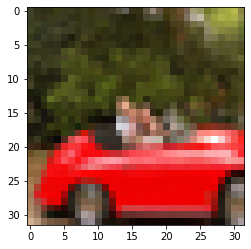

In [60]:
plt.imshow(img_t.permute(1,2,0))
plt.show()

## Normalize the CIFAR-10 dataset

In [13]:
imgs = torch.stack([img_t for img_t, _ in tensor_cifar10], dim =3)
imgs.shape

torch.Size([3, 32, 32, 50000])

In [40]:
imgs.view(3, -1).mean(dim=1)

tensor([0.4915, 0.4823, 0.4468])

In [15]:
imgs.view(3, -1).std(dim=1)

tensor([0.2470, 0.2435, 0.2616])

In [16]:
transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616))

Normalize(mean=(0.4915, 0.4823, 0.4468), std=(0.247, 0.2435, 0.2616))

In [17]:
tfms = transforms.Compose([transforms.ToTensor(), 
                           transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616))])

In [18]:
transformed_cifar10 = datasets.CIFAR10(data_path, train=True, download = False, transform = tfms)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


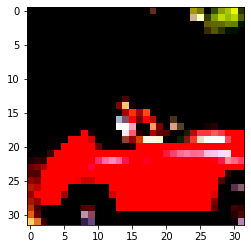

In [19]:
img_t, _ = transformed_cifar10[99]
plt.imshow(img_t.permute(1,2,0))
plt.show()

## Goal: Distinguish birds from airplanes

In [63]:
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

In [64]:
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

In [65]:
label_map = {0:0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label]) for img, label in cifar10 if label in [0, 2]]
cifar2_val = [(img, label_map[label]) for img, label in cifar10_val if label in [0, 2]]

In [66]:
n_out = 2

In [67]:
model = nn.Sequential(nn.Linear(3072, 512), nn.Tanh(), nn.Linear(512, n_out)) #512 is arbitrary

In [68]:
def softmax(x):
    return torch.exp(x)/torch.exp(x).sum()

In [69]:
x = torch.tensor([1.0, 2.0, 3.0])
softmax(x)

tensor([0.0900, 0.2447, 0.6652])

In [70]:
softmax(x).sum()

tensor(1.)

In [71]:
softmax = nn.Softmax(dim=1)

In [72]:
x = torch.tensor([[1.0, 2.0, 3.0],
                 [1.0, 2.0, 3.0]])

In [73]:
softmax(x)

tensor([[0.0900, 0.2447, 0.6652],
        [0.0900, 0.2447, 0.6652]])

## Now lets output probabilities:

In [74]:
model = nn.Sequential(nn.Linear(3072, 512),
                     nn.Tanh(), 
                     nn.Linear(512, 2), 
                     nn.Softmax(dim=1))

In [80]:
img, _ = cifar2[0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


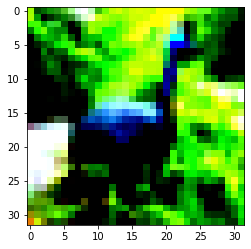

In [81]:
img, _ = cifar2[0]

plt.imshow(img.permute(1, 2, 0))
plt.show()

In [82]:
img_batch = img.view(-1).unsqueeze(0)

In [83]:
out = model(img_batch)
out

tensor([[0.5392, 0.4608]], grad_fn=<SoftmaxBackward>)

In [84]:
_, index = torch.max(out, dim=1)

In [85]:
index

tensor([0])

In [86]:
model = nn.Sequential(nn.Linear(3072, 512),
                     nn.Tanh(), 
                     nn.Linear(512, 2), 
                     nn.LogSoftmax(dim=1))


In [88]:
# Negative log-likelihood
# When the likelihood is high, the loss is low and vice versa
loss = nn.NLLLoss()

In [89]:
img, label = cifar2[0]
out = model(img.view(-1).unsqueeze(0))

In [90]:
loss(out, torch.tensor([label]))

tensor(0.6274, grad_fn=<NllLossBackward>)

## Re do training

In [6]:
import torch.optim as optim

In [7]:
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

In [8]:
label_map = {0:0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label]) for img, label in cifar10 if label in [0, 2]]
cifar2_val = [(img, label_map[label]) for img, label in cifar10_val if label in [0, 2]]

In [11]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size = 64, shuffle = True)

In [12]:
model = nn.Sequential(nn.Linear(3072, 512),
                     nn.Tanh(), 
                     nn.Linear(512, 2), 
                     nn.LogSoftmax(dim=1))

In [13]:
learning_rate = 1e-2
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.NLLLoss()
n_epochs= 100

In [17]:
for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        batch_size = imgs.shape[0]
        outputs = model(imgs.view(batch_size, -1))
        loss = loss_fn(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(f"Epoch: {epoch:d}, Loss: {float(loss):.2f}")

Epoch: 0, Loss: 0.53
Epoch: 1, Loss: 0.33
Epoch: 2, Loss: 0.51
Epoch: 3, Loss: 0.55
Epoch: 4, Loss: 0.69
Epoch: 5, Loss: 0.43
Epoch: 6, Loss: 0.16
Epoch: 7, Loss: 0.52
Epoch: 8, Loss: 0.34
Epoch: 9, Loss: 0.65
Epoch: 10, Loss: 0.39
Epoch: 11, Loss: 0.34
Epoch: 12, Loss: 0.46
Epoch: 13, Loss: 0.41
Epoch: 14, Loss: 0.17
Epoch: 15, Loss: 0.34
Epoch: 16, Loss: 0.28
Epoch: 17, Loss: 0.63
Epoch: 18, Loss: 0.29
Epoch: 19, Loss: 0.36
Epoch: 20, Loss: 0.24
Epoch: 21, Loss: 0.26
Epoch: 22, Loss: 0.14
Epoch: 23, Loss: 0.46
Epoch: 24, Loss: 0.14
Epoch: 25, Loss: 0.29
Epoch: 26, Loss: 0.20
Epoch: 27, Loss: 0.37
Epoch: 28, Loss: 0.28
Epoch: 29, Loss: 0.44
Epoch: 30, Loss: 0.27
Epoch: 31, Loss: 0.19
Epoch: 32, Loss: 0.18
Epoch: 33, Loss: 0.12
Epoch: 34, Loss: 0.27
Epoch: 35, Loss: 0.17
Epoch: 36, Loss: 0.12
Epoch: 37, Loss: 0.16
Epoch: 38, Loss: 0.10
Epoch: 39, Loss: 0.27
Epoch: 40, Loss: 0.14
Epoch: 41, Loss: 0.14
Epoch: 42, Loss: 0.09
Epoch: 43, Loss: 0.05
Epoch: 44, Loss: 0.16
Epoch: 45, Loss: 0.1

In [18]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size = 64, shuffle=False)

In [19]:
correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        batch_size = imgs.shape[0]
        outputs = model(imgs.view(batch_size, -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
    print(f"Accuracy:{correct/total}")

          

Accuracy:0.8115


In [ ]:
#Instead of Softmax and NLLLoss we can combine and use CrossEntropyLoss

model = nn.Sequential(nn.Linear(3072, 512),
                     nn.Tanh(), 
                     nn.Linear(512, 2)
                     )

loss_fn = nn.CrossEntropyLoss()

In [20]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(1574402, [1572864, 512, 1024, 2])